## Training DCGAN for generation of handwritten digits

In [14]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim

import matplotlib.animation as animation
from IPython.display import HTML
from torchvision import datasets, utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training on device", device)

Training on device cpu


In [2]:
# number of subprocesses to use for data loading
num_workers = 4
# number of samples per batch to load
batch_size = 64

transform = transforms.ToTensor()

#data_path = 'MNIST/processed/training.pt'

train_data = datasets.MNIST(root = "data", download=True, train=True, transform=transform )

train_loader = torch.utils.data.DataLoader(dataset = train_data, 
                                           batch_size = batch_size, 
                                           num_workers = num_workers, 
                                           shuffle = True)


100.1%

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


28.4%

0.0%5%

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


100.4%

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


180.4%/Users/elliemcintosh/miniconda3/envs/py38/lib/python3.8/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


In [3]:
# depending on the batch size last batch might not have the batch_size num images
# need to consider the differentrce when generating labels for the lst batch!!!
print("batch size: ", batch_size)
print("number of batches: ", len(train_loader))
print("number of images in the last batch: ", len(train_loader.dataset) - batch_size*(len(train_loader)-1))

batch size:  64
number of batches:  938
number of images in the last batch:  32


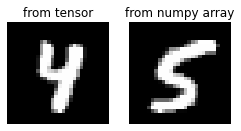

In [4]:
# get a single batch of training images:
dataiter = iter(train_loader)
images, labels = dataiter.next()

#to dsiplay as a tensor image permute the chanel as the last dim
plt.figure(figsize=(4,8))

plt.subplot(1,2,1)
plt.axis("off")
plt.title("from tensor")
plt.imshow(images[0].permute(1,2,0), cmap='gray')


#to display as a numpy array image squeezing out the chanel dim
img = np.squeeze(images[1])

plt.subplot(1,2,2)
plt.axis("off")
plt.title("from numpy array")
plt.imshow(img.numpy(), cmap='gray')

## DCGAN Model

*GAN* is comprise of two networks, a Generator and a Discriminator competing against each other. Generator learns to turn random noise input into images that look like an image of a handwritten digit from the MNIST dataset. Simultaneously, the Discriminator learns to distinguish the fake images produced by the Generator from the genuine ones coming from the training dataset.

**DCGANs** are a class of convolutional GANs, where both the generator and discriminator networks are comprised of convolutional neural networks (CNNs).


![alt text](DCGAN_model.png "DCGAN model architecture")


* DCGAN is a more stable architecture for training generative adversarial networks

* DCGAN eliminate fully connected layers and replace all the max pooling layers with convolutional strides

* DCGAN trains with the Adam optimizer which is far better when training deep neural networks

* DCGAN uses batch normalization - normalize the inputs to each layer, for each training mini-batch as it flows through the network. Normalization makes the training process less sensitive to the scale of the features. Batch normalization solves the problem of ***covariate shift*** - variations in input value distributions between layers during training, by scaling values in each mini-batch by the mean and variance of that mini-batch [nn.BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html). Batch normalization limits the amount by which updating the parameters in the previous layers can affect the distribution of inputs received by the current layer. This decreases any unwanted interdependence between parameters across layers, which helps speed up the network training process and increase its robustness, especially when it comes to network parameter initialization.


### Set model hyperparameters

In [15]:
#set random seed for reproducibility
seed = 123
random.seed(seed)
torch.manual_seed(seed)

z_dim = 100 
batch_size = 64
num_epochs = 50

# Create batch of latent vectors for visualizing the progress of the generator
fixed_noise = torch.randn(batch_size, z_dim, device=device)

### Generator

An fully connected linear layer reshapes a noise vector z that thakes in an random latent vector and reshapes it into a three-dimensional hidden layer with a small base (width × height) and large depth (chanels). Using transposed convolutions, the input is progressively reshaped such that its base grows while its depth decreases until the final layer where the shape of the generated image is 1 x 28 × 28.

![alt text](DCGAN_Generator.png "Generator model architecture")

After each transposed convolution layer batch noramlization is applied and the [Leaky ReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html) as an activation function. Leaky ReLU has a small non-zero output for negative input and thus allows a gradients to flow backwards through the layer preventing the from dying out during training. The activation function applied to the output layer is *tahn* with output values in [-1, 1] which tends to produce sharper images than the *sigmoid* . NB: Need to scale the input images to have pixel values in the same range when training the discriminator.

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        
        self.fc1 = nn.Linear(z_dim, 256*7*7, bias= False)
        
        self.deconv1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2, padding=0, bias=False)
        self.batchn1 = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(in_channels=128, out_channels=64,  kernel_size=1, stride=1, padding=0, bias=False)
        self.batchn2 = nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(in_channels=64, out_channels=1,  kernel_size=2, stride=2, padding=0, bias=False)
              
        
    def forward(self, input):
        
        x = self.fc1(input)
        x = x.view(-1,256, 7, 7)
        x = self.deconv1(x)
        x = self.batchn1(x)
        x = F.leaky_relu(x) # default negative_slope of 0.01
        x = self.deconv2(x)
        x = self.batchn2(x)
        x = F.leaky_relu(x)
        x = self.deconv3(x)
        
        output = torch.tanh(x) 
        
        return output

### Discriminator

A convolutional network which takes 1x28x28 image, applies several convolutional layers and using sigmoid activation function, outputs a probability if the input image is real or fake. The input image is transformed such that its base (width × height) gets progressively smaller and its depth (channels) gets progressively deeper. On all convolutional layers Leaky ReLU activation function is applyed. Batch normalization is used on all convolutional layers except the firs one.

![alt text](DCGAN_Discriminator.png "Discriminator model architecture")

In [7]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=2, stride=2, padding=0, bias=True)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=2, stride=2, padding=0, bias=True)
        self.batchn1 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=2, stride=2, padding=0, bias=True)
        self.batchn2 = nn.BatchNorm2d(128)
        
        self.fc1   = nn.Linear(128*3*3, 1, bias=True)
        
    def forward(self, input):
        
        x = self.conv1(input)
        x = F.leaky_relu(x)
        x = self.conv2(x)
        x = self.batchn1(x)
        x = F.leaky_relu(x)
        x = self.conv3(x)
        x = self.batchn2(x)
        x = F.leaky_relu(x)
        x = x.view(-1, 128*3*3)
        
        x = self.fc1(x)
        
        output = torch.sigmoid(x)
        
        return output
    

In [8]:
netG = Generator().to(device)
netD = Discriminator().to(device)

In [9]:
#check if Generator is working with batch of random noise latent vectors
noise = torch.randn(batch_size, z_dim, device=device)
print("random noise vector of size:", noise.size())
output = netG(noise)
print("generator output size:", output.size())

random noise vector of size: torch.Size([64, 100])
generator output size: torch.Size([64, 1, 28, 28])


In [10]:
# check if the Discriminator model runs
dataiter = iter(train_loader)
images, _ = dataiter.next()

labels = torch.full((batch_size,), 1, dtype=torch.float)
output = netD(images)

# sigmoid + binary_cross_entropy
def sigmoid(x): return (1 + (-x).exp()).reciprocal()

def binary_cross_entropy(x, y): return -(x.log()*y + (1-y)*(1-x).log()).mean()

loss = binary_cross_entropy(output.squeeze(), labels)
print("Loss of a batch of real images: ", loss)

Loss of a batch of real images:  tensor(1.0200, grad_fn=<NegBackward>)


### Loss Functions

Use the Binary Cross Entropy Loss, [BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html).

\begin{equation*}
\ l(x, y)=L= ( l_1, l_2,  ... , l_N ) ^T, 
\        l= - [y_n.log x_n + (1 - y_n).log(1-x_n)]
\end{equation*}

This function provides the calculation of both log components log(D(x))
 and log(1−D(G(z))). We can specify what part of the BCE equation to use with the y input, so changing the G and D labels makes the computation of the different loss functions happen. 

In GAN papers, the loss function to optimize G is min(log(1-D(G(z)))), but in practice max(log(D(G(z)))) is used.

because the first formulation has vanishing gradients early on



In [11]:
#init the BCELoss function
loss_fn = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

### Optimizers

Generator and Discriminator get updated separetly so two separate Adam Optimizers are used 

In [12]:
#Set up Adam optimizers for the Generator and Discriminator
optimizerG= optim.Adam(netG.parameters(), lr = 0.001)
optimizerD = optim.Adam(netD.parameters(), lr = 0.001)

### Training

#### Train the Discriminator

Training the discriminator is to maximize the probability of correctly classifying a given input image as real or fake, thus maximizing *log(D(x))+log(1−D(G(z)))*, which if use two separate mini batches results in the following steps: 

1. Construct a batch of real samples from the training set, forward   pass through D, calculate the loss *log(D(x))*, then calculate the gradients in a backward pass. 

2. Construct a batch of fake samples with the current generator, forward pass this batch through D, calculate the loss *log(1−D(G(z)))*, and accumulate the gradients with a backward pass. 
 
3. With the gradients accumulated from both the all-real and all-fake batches call the Discriminator’s optimizer.


#### Train the Generator

Train the Generator by minimizing *log(1−D(G(z)))* in an effort to generate better fakes. But since this does not provide sufficient gradients we intead maximize *log(D(G(z)))*: 

1. Classify the Generator output from training the Dprevious part with the Discriminator, computing G’s loss using real labels as GT, this allows us to use the *log(x)* part of the BCELoss, rather than the *log(1−x)*

2. Compute G’s gradients in a backward pass

3. Update G’s parameters with an optimizer step


#### Training statistics

  * Loss_D - discriminator loss calculated as the sum of losses for the all real and all fake batches *(log(D(x))+log(D(G(z))))*
  * Loss_G - generator loss calculated as *log(D(G(z)))*
  * *D(x)* - the average discriminator output across the batch for the all real batch
  * *D(G(z))* - average discriminator outputs for the all fake batch. The first number is before D is updated and the second number is after D is updated
  
  
####   Tracking the progress of Generator

At the end of each epoch push our fixed_noise batch through the generator to visually track the progress of G’s training.

In [18]:
# Lists to keep track of progress
G_losses = []
D_losses = []

fixed_fake_imgs =[]

print_every = 350

# train the GAN network
netD.train()
netG.train()

for epoch in range(num_epochs):
        
    #for each batch in the train loader
    for batch_idx, (real_imgs, _ ) in enumerate(train_loader):

        num_imgs = real_imgs.size()[0]
        
        real_imgs.to(device)
               
        ###############################################################
        #                                                             #
        # Update Discirminator: maximize log(D(x)) + log(1 - D(G(z))) #
        #                                                             #
        ###############################################################
                  
        optimizerD.zero_grad()
              
        #################### Train with real images ###################
     
        # rescale input images from [0, 1] to [-1, 1]
        real_imgs = real_imgs * 2 - 1
        
        labels = torch.full((num_imgs,), real_label, dtype=torch.float, device = device)
        
        output = netD(real_imgs)
        
        # compute the Discriminator losses on real images
        real_lossD =  loss_fn(output.squeeze(), labels)
        
        # compute the gradient of the real images loss w.r.t. Discriminator model parameters
        real_lossD.backward(retain_graph=True)
        
                
        ################### Train with fake images ########################
        
        # generate batch of latent vectors - tensors with random numbers from the standart normal distr 
        noise = torch.randn(num_imgs, z_dim, device=device)
        
        # generate batch of fake images 
        fake_imgs = netG(noise)
        
        labels = torch.full((num_imgs,), fake_label, dtype=torch.float, device = device)
        
        # classify the batch of fake images with the Discriminator
        output = netD(fake_imgs) 
        
        # compute the Discriminator losses on batch of fake images
        fake_lossD =  loss_fn(output.squeeze(), labels)
        
        # compute the gradient of the fake images loss w.r.t. Discriminator model parameters
        fake_lossD.backward(retain_graph=True)
        
        # add up losses from classifing a batch of real and  a batch of fake images
        lossD = real_lossD + fake_lossD
        
        # update the Discriminator weights
        optimizerD.step()
        
           
        ###############################################################
        #                                                             #
        #           Update Generator: maximize log(D(G(z)))           #
        #                                                             #
        ###############################################################
        
        optimizerG.zero_grad()
            
        # since the generator's goal is to get netD(fake_images) = 1, we flip the labels for computing Generator's loss
        labels = torch.full((num_imgs,), real_label, dtype=torch.float, device = device)    
        
        # perform another forward pass with the batch of fake images through the Discriminator, after it was updated in the previus step
        output = netD(fake_imgs)
        
        # compute the Generator's loss on this output
        lossG = loss_fn(output.squeeze(), labels)
        
        # compute the gradient of the fake images (called "real") loss w.r.t. Generator model parameters
        lossG.backward()
        
        # update the Generator weights
        optimizerG.step()
        
        
        ###############################################################
        #                                                             #
        #                    Output training stats                    #
        #                                                             #
        ###############################################################
        
        # print out training stats every chosen number of batches
        if batch_idx % print_every == 0:
            
            print('Epoch {}/{}  Batch {}/{}'.format(epoch +1, num_epochs, batch_idx, len(train_loader)))
            print('-'*30)
            print('discriminator loss: {:6.4f}, generator loss: {:6.4f}'.format(lossD.item(), lossG.item()))
            print()
            
        # save losses for plotting
        G_losses.append(lossG.item())
        D_losses.append(lossD.item())
        
    ############################ after each epoch  #########################
    print()
    # check how the Generator is doing by saving/displaing the fixed noise generated fake images
    netG.eval()
    with torch.no_grad():
        fixed_fake = netG(fixed_noise).detach().cpu()
        # turn a 1D vectors into 2D gray scale images in order to diplay
        displ_imgs = fixed_fake.view(-1, 1, 28, 28)
        fixed_fake_imgs.append(torchvision.utils.make_grid(displ_imgs, padding=2, normalize=True))
    netG.train()    
        

Epoch 1/20  Batch 0/938
------------------------------
discriminator loss: 1.3192, generator loss: 0.8459

Epoch 1/20  Batch 350/938
------------------------------
discriminator loss: 0.0389, generator loss: 6.3324

Epoch 1/20  Batch 700/938
------------------------------
discriminator loss: 0.1210, generator loss: 4.7339


Epoch 2/20  Batch 0/938
------------------------------
discriminator loss: 0.3736, generator loss: 2.5731

Epoch 2/20  Batch 350/938
------------------------------
discriminator loss: 0.3645, generator loss: 3.0832

Epoch 2/20  Batch 700/938
------------------------------
discriminator loss: 0.0352, generator loss: 5.4842


Epoch 3/20  Batch 0/938
------------------------------
discriminator loss: 0.2193, generator loss: 3.9649

Epoch 3/20  Batch 350/938
------------------------------
discriminator loss: 0.2844, generator loss: 3.7242

Epoch 3/20  Batch 700/938
------------------------------
discriminator loss: 0.0632, generator loss: 6.6459


Epoch 4/20  Batch 0/93

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1/50
------------------------------
 Avg. Discriminator loss: 0.1304, Avg Generator loss: 4.7673

Epoch  1


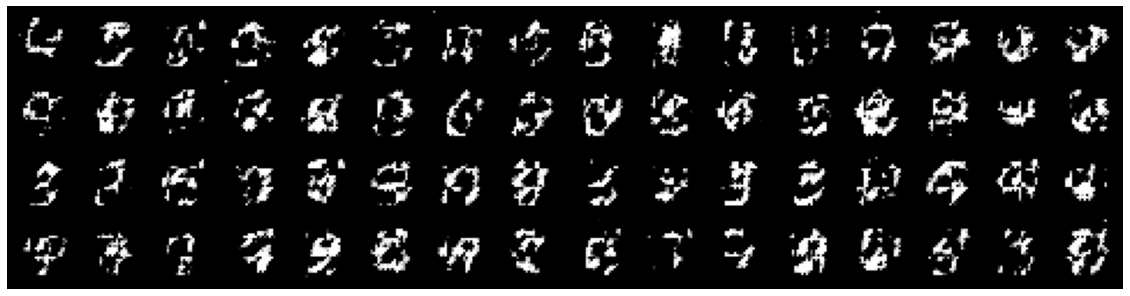

Epoch 2/50
------------------------------
 Avg. Discriminator loss: 0.1315, Avg Generator loss: 4.7122

Epoch 3/50
------------------------------
 Avg. Discriminator loss: 0.1505, Avg Generator loss: 4.5847

Epoch 4/50
------------------------------
 Avg. Discriminator loss: 0.1626, Avg Generator loss: 4.5088

Epoch 5/50
------------------------------
 Avg. Discriminator loss: 0.1777, Avg Generator loss: 4.4319

Epoch 6/50
------------------------------
 Avg. Discriminator loss: 0.1900, Avg Generator loss: 4.3679

Epoch 7/50
------------------------------
 Avg. Discriminator loss: 0.1991, Avg Generator loss: 4.3232

Epoch 8/50
------------------------------
 Avg. Discriminator loss: 0.2047, Avg Generator loss: 4.2853

Epoch 9/50
------------------------------
 Avg. Discriminator loss: 0.2127, Avg Generator loss: 4.2493

Epoch 10/50
------------------------------
 Avg. Discriminator loss: 0.2162, Avg Generator loss: 4.2243



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 11/50
------------------------------
 Avg. Discriminator loss: 0.2195, Avg Generator loss: 4.2079

Epoch  11


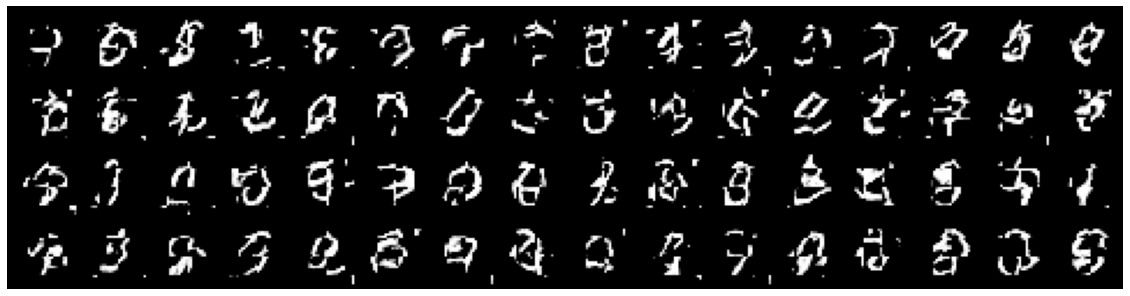

Epoch 12/50
------------------------------
 Avg. Discriminator loss: 0.2223, Avg Generator loss: 4.1932

Epoch 13/50
------------------------------
 Avg. Discriminator loss: 0.2250, Avg Generator loss: 4.1821

Epoch 14/50
------------------------------
 Avg. Discriminator loss: 0.2279, Avg Generator loss: 4.1753

Epoch 15/50
------------------------------
 Avg. Discriminator loss: 0.2301, Avg Generator loss: 4.1663

Epoch 16/50
------------------------------
 Avg. Discriminator loss: 0.2316, Avg Generator loss: 4.1657

Epoch 17/50
------------------------------
 Avg. Discriminator loss: 0.2327, Avg Generator loss: 4.1655

Epoch 18/50
------------------------------
 Avg. Discriminator loss: 0.2341, Avg Generator loss: 4.1680

Epoch 19/50
------------------------------
 Avg. Discriminator loss: 0.2347, Avg Generator loss: 4.1675

Epoch 20/50
------------------------------
 Avg. Discriminator loss: 0.2365, Avg Generator loss: 4.1688



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 21/50
------------------------------
 Avg. Discriminator loss: 0.2367, Avg Generator loss: 4.1733

Epoch  21


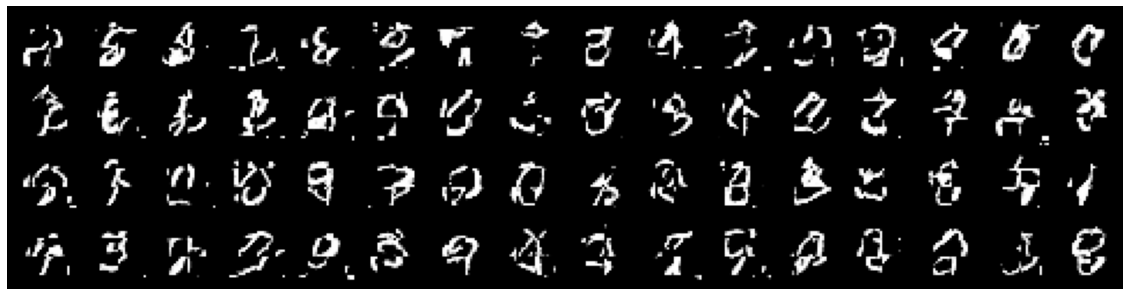

Epoch 22/50
------------------------------
 Avg. Discriminator loss: 0.2367, Avg Generator loss: 4.1788

Epoch 23/50
------------------------------
 Avg. Discriminator loss: 0.2372, Avg Generator loss: 4.1821

Epoch 24/50
------------------------------
 Avg. Discriminator loss: 0.2372, Avg Generator loss: 4.1894

Epoch 25/50
------------------------------
 Avg. Discriminator loss: 0.2369, Avg Generator loss: 4.1962

Epoch 26/50
------------------------------
 Avg. Discriminator loss: 0.2369, Avg Generator loss: 4.2032

Epoch 27/50
------------------------------
 Avg. Discriminator loss: 0.2369, Avg Generator loss: 4.2093

Epoch 28/50
------------------------------
 Avg. Discriminator loss: 0.2372, Avg Generator loss: 4.2160

Epoch 29/50
------------------------------
 Avg. Discriminator loss: 0.2367, Avg Generator loss: 4.2228

Epoch 30/50
------------------------------
 Avg. Discriminator loss: 0.2363, Avg Generator loss: 4.2317



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 31/50
------------------------------
 Avg. Discriminator loss: 0.2361, Avg Generator loss: 4.2389

Epoch  31


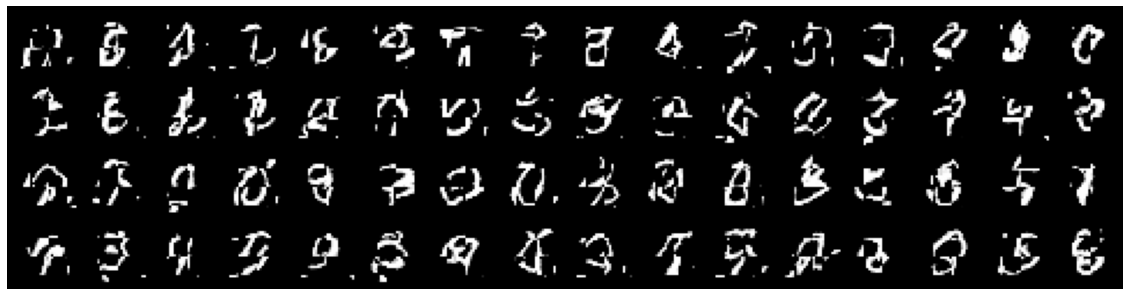

Epoch 32/50
------------------------------
 Avg. Discriminator loss: 0.2363, Avg Generator loss: 4.2458

Epoch 33/50
------------------------------
 Avg. Discriminator loss: 0.2360, Avg Generator loss: 4.2550

Epoch 34/50
------------------------------
 Avg. Discriminator loss: 0.2357, Avg Generator loss: 4.2629

Epoch 35/50
------------------------------
 Avg. Discriminator loss: 0.2352, Avg Generator loss: 4.2718

Epoch 36/50
------------------------------
 Avg. Discriminator loss: 0.2347, Avg Generator loss: 4.2800

Epoch 37/50
------------------------------
 Avg. Discriminator loss: 0.2343, Avg Generator loss: 4.2881

Epoch 38/50
------------------------------
 Avg. Discriminator loss: 0.2341, Avg Generator loss: 4.2970

Epoch 39/50
------------------------------
 Avg. Discriminator loss: 0.2334, Avg Generator loss: 4.3056

Epoch 40/50
------------------------------
 Avg. Discriminator loss: 0.2325, Avg Generator loss: 4.3168



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 41/50
------------------------------
 Avg. Discriminator loss: 0.2320, Avg Generator loss: 4.3266

Epoch  41


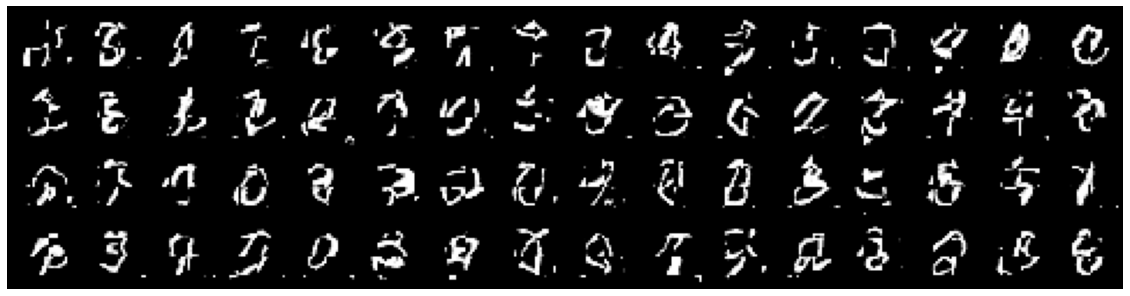

Epoch 42/50
------------------------------
 Avg. Discriminator loss: 0.2311, Avg Generator loss: 4.3363

Epoch 43/50
------------------------------
 Avg. Discriminator loss: 0.2306, Avg Generator loss: 4.3465

Epoch 44/50
------------------------------
 Avg. Discriminator loss: 0.2298, Avg Generator loss: 4.3563

Epoch 45/50
------------------------------
 Avg. Discriminator loss: 0.2289, Avg Generator loss: 4.3676

Epoch 46/50
------------------------------
 Avg. Discriminator loss: 0.2279, Avg Generator loss: 4.3793

Epoch 47/50
------------------------------
 Avg. Discriminator loss: 0.2274, Avg Generator loss: 4.3900

Epoch 48/50
------------------------------
 Avg. Discriminator loss: 0.2265, Avg Generator loss: 4.4018

Epoch 49/50
------------------------------
 Avg. Discriminator loss: 0.2258, Avg Generator loss: 4.4119

Epoch 50/50
------------------------------
 Avg. Discriminator loss: 0.2246, Avg Generator loss: 4.4244



In [16]:
# Lists to keep track of progress
G_losses = []
D_losses = []

fixed_fake_imgs =[]

display_every = 10

# train the GAN network
netD.train()
netG.train()

for epoch in range(num_epochs):
        
    #for each batch in the train loader
    for batch_idx, (real_imgs, _ ) in enumerate(train_loader):

        num_imgs = real_imgs.size()[0]
        
        real_imgs.to(device)
               
        ###############################################################
        #                                                             #
        # Update Discirminator: maximize log(D(x)) + log(1 - D(G(z))) #
        #                                                             #
        ###############################################################
                  
        optimizerD.zero_grad()
              
        #################### Train with real images ###################
     
        # rescale input images from [0, 1] to [-1, 1]
        real_imgs = real_imgs * 2 - 1
        
        labels = torch.full((num_imgs,), real_label, dtype=torch.float, device = device)
        
        output = netD(real_imgs)
        
        # compute the Discriminator losses on real images
        real_lossD =  loss_fn(output.squeeze(), labels)
        
        # compute the gradient of the real images loss w.r.t. Discriminator model parameters
        real_lossD.backward(retain_graph=True)
        
                
        ################### Train with fake images ########################
        
        # generate batch of latent vectors - tensors with random numbers from the standart normal distr 
        noise = torch.randn(num_imgs, z_dim, device=device)
        
        # generate batch of fake images 
        fake_imgs = netG(noise)
        
        labels = torch.full((num_imgs,), fake_label, dtype=torch.float, device = device)
        
        # classify the batch of fake images with the Discriminator
        output = netD(fake_imgs) 
        
        # compute the Discriminator losses on batch of fake images
        fake_lossD =  loss_fn(output.squeeze(), labels)
        
        # compute the gradient of the fake images loss w.r.t. Discriminator model parameters
        fake_lossD.backward(retain_graph=True)
        
        # add up losses from classifing a batch of real and  a batch of fake images
        lossD = real_lossD + fake_lossD
        
        # update the Discriminator weights
        optimizerD.step()
        
           
        ###############################################################
        #                                                             #
        #           Update Generator: maximize log(D(G(z)))           #
        #                                                             #
        ###############################################################
        
        optimizerG.zero_grad()
            
        # since the generator's goal is to get netD(fake_images) = 1, we flip the labels for computing Generator's loss
        labels = torch.full((num_imgs,), real_label, dtype=torch.float, device = device)    
        
        # perform another forward pass with the batch of fake images through the Discriminator, after it was updated in the previus step
        output = netD(fake_imgs)
        
        # compute the Generator's loss on this output
        lossG = loss_fn(output.squeeze(), labels)
        
        # compute the gradient of the fake images (called "real") loss w.r.t. Generator model parameters
        lossG.backward()
        
        # update the Generator weights
        optimizerG.step()
                    
        # save losses for plotting
        G_losses.append(lossG.item())
        D_losses.append(lossD.item())
        
    ############################ after each epoch  #########################
    
    # print out training stats
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-'*30)
    print(' Avg. Discriminator loss: {:6.4f}, Avg Generator loss: {:6.4f}'.format(sum(D_losses)/len(D_losses), sum(G_losses)/len(G_losses)))
    print()  
    
    # check how the Generator is doing by displaing the fixed noise generated fake images
    if epoch % display_every == 0:
        
        netG.eval()
        with torch.no_grad():
            
            fixed_fake = netG(fixed_noise).detach().cpu()
            # turn a 1D vectors into 2D gray scale images in order to diplay
            displ_imgs = fixed_fake.view(-1, 1, 28, 28)
            #to display images
            image_grid = torchvision.utils.make_grid((displ_imgs+1)/2, nrow=16)
            #for animation
            fixed_fake_imgs.append(torchvision.utils.make_grid(displ_imgs, padding=2, normalize=True))
            
            print("Epoch ", epoch + 1)
            plt.figure(figsize=(20,10))
            plt.imshow(image_grid.permute(1, 2, 0))
            plt.axis("off")
            plt.pause(0.05)
        netG.train()

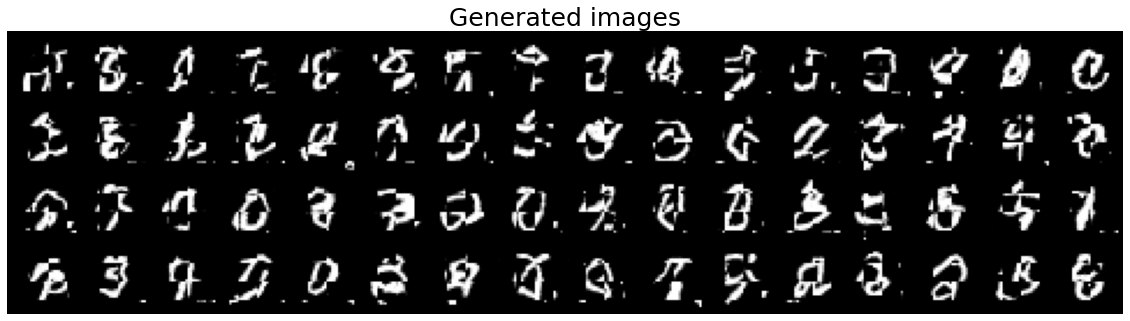

In [21]:
image_grid = torchvision.utils.make_grid((displ_imgs+1)/2, nrow=16)
plt.figure(figsize=(20,10))
plt.imshow(image_grid.permute(1, 2, 0))
plt.title("Generated images", fontsize=25)
plt.axis("off")
plt.pause(0.05)

Comparison of the fake, generated images with a batch of real training images:

(-0.5, 481.5, 121.5, -0.5)

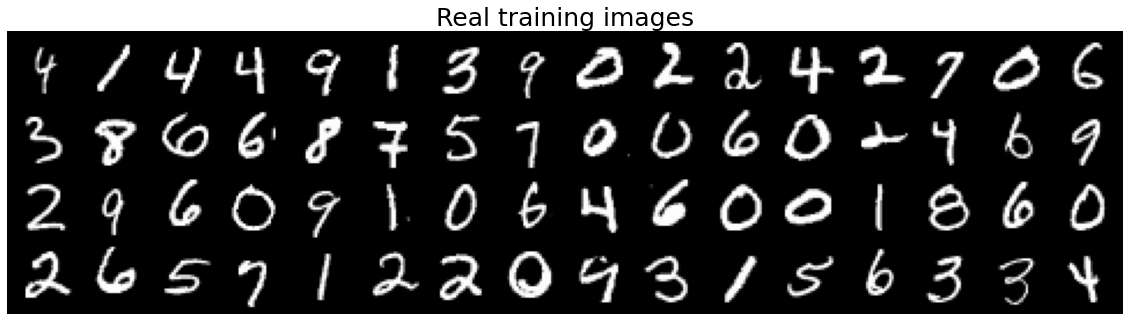

In [24]:
dataiter = iter(train_loader)
images, _ = dataiter.next()

image_grid = torchvision.utils.make_grid(images, nrow=16)

plt.figure(figsize=(20,10))
plt.title("Real training images", fontsize=25)
plt.imshow(image_grid.permute(1, 2, 0))
plt.axis("off")

### Results

Display three different results:

  * Loss vs training itterations for the Discriminator and Generator
  * Generator's output on the fixed noise batch for every epoch
  * Batch of real and generated fake images

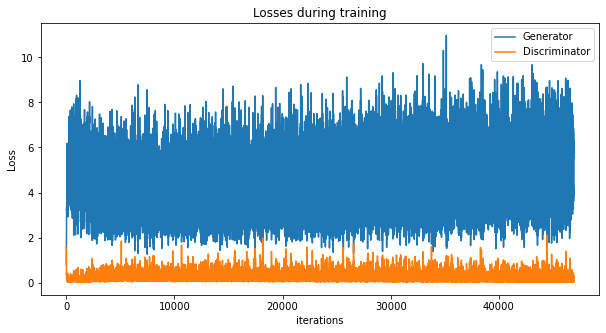

In [25]:
plt.figure(figsize=(10,5))
plt.title("Losses during training")
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

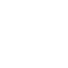

In [29]:
# animate the saved Generator's output on the fixed_noise batch
#%%capture
fig = plt.figure(figsize=(2,1))
plt.axis("off")

imgs = [[plt.imshow(np.transpose(img,(1,2,0)), animated=True)] for img in fixed_fake_imgs]

ani = animation.ArtistAnimation(fig, imgs, interval=100, repeat_delay=1000, blit=True)
plt.show()
HTML(ani.to_jshtml())

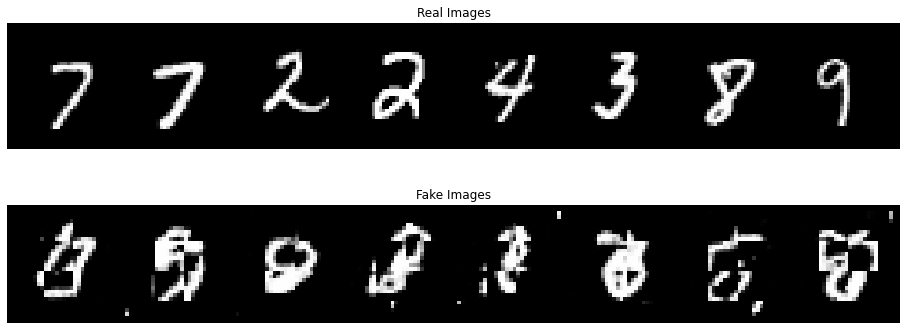

In [21]:
real_imgs_batch = next(iter(train_loader))

# Plot the real images figuresize(nrows, ncols))
plt.figure(figsize=(16, 6))
plt.subplot(2,1,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_imgs_batch[0].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(2,1,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(fixed_fake_imgs[-1],(1,2,0)))